In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import celerite as celery
import exoplanet as xo
np.random.seed(42)
%matplotlib inline

data_dir = '/Users/mbedell/python/pmodes/experiments/data/'

In [2]:
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP

In [3]:
d = np.genfromtxt(data_dir+'sim_oneyear.csv', names=True, dtype=None, delimiter=',')
ts_all = np.copy(d['ts'])
rvs_all = np.copy(d['rvs'])
xs_all = np.copy(d['xs'])

In [4]:
from scipy.interpolate import interp1d

def simulate_exposure(ts, rvs, start_time, exp_time):
    pad = 100. # seconds - ARBITRARY
    smaller_inds = (ts > (start_time - pad)) & (ts < (start_time + exp_time + pad))    
    interp = interp1d(ts[smaller_inds], rvs[smaller_inds], kind='cubic')
    tiny = 0.1 # 100 ms
    fine_ts = np.arange(start_time, start_time+exp_time, tiny) # fine grid
    fine_rvs = interp(fine_ts)
    return np.sum(fine_rvs)/len(fine_rvs) # ASSUMES EVEN WEIGHTING - technically incorrect for last point

#### observe for 15 consecutive 1-min integrations every night

In [5]:
start_ts = np.arange(30,90) * 3600. * 24. # nightly for 60 consecutive nights
start_ts += np.random.randint(-60, 60, 60)*60. # random perturbation of up to an hour before/after - can only be whole minutes to avoid interpolation
assert np.isin(start_ts, ts_all).all(), "Bad timestamp!"

In [6]:
ts = np.ravel([np.arange(15) * 60. + t for t in start_ts])
rvs = np.ravel([rvs_all[ts_all == t] for t in ts])
errs = np.zeros_like(ts) + 0.5

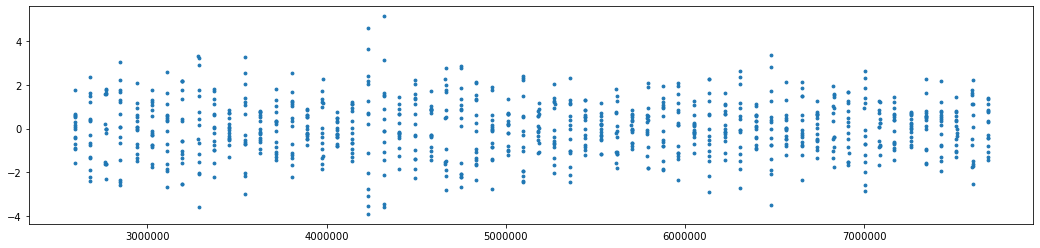

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))
ax.scatter(ts, rvs, s=8);

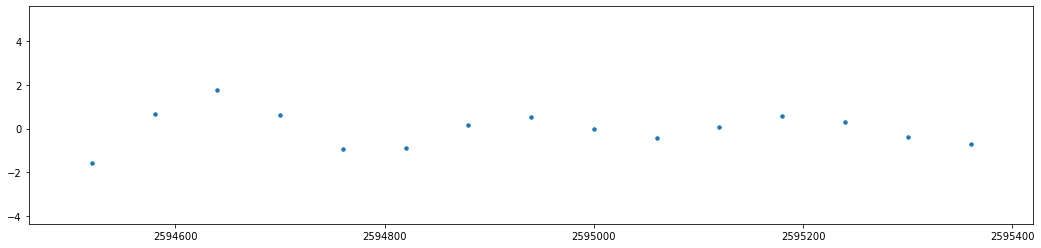

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))
ax.scatter(ts, rvs, s=12)
ax.set_xlim([start_ts[0] - 60, start_ts[0] + 900]);

In [9]:
t = ts
y = rvs
yerr = errs
t_grid = np.ravel([np.linspace(t - 60, t + 900, 100) for t in start_ts]) # fine grid around the observed times

In [10]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
23it [00:00, 53.84it/s, logp=-8.309949e+02] 
message: Optimization terminated successfully.
logp: -1003.6837487153452 -> -830.9949448433914


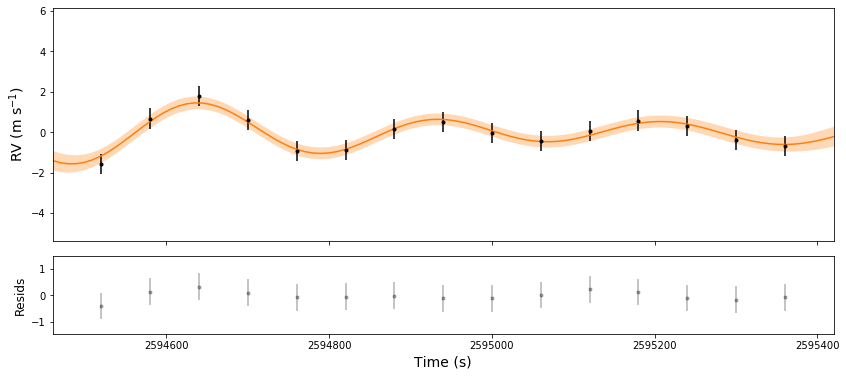

In [11]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})
                              
art = ax1.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_grid, mu, color="C1", label="prediction")

ax1.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")

ax2.errorbar(t, y - y_pred, yerr=yerr, fmt=".k", capsize=0, label="resids", alpha=0.3)

ax2.set_xlabel('Time (s)', fontsize=14)
ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=14)
ax2.set_ylabel('Resids', fontsize=12)

ax1.set_xlim([start_ts[0] - 60, start_ts[0] + 900]);

In [12]:
print("net RMS = {0:.2f} m/s".format(np.sqrt(np.sum((y - y_pred)**2/len(y)))))

net RMS = 0.18 m/s


#### 15 consecutive observations per night, but random nights

In [13]:
start_ts = np.random.choice(360, 60, replace=False) * 3600. * 24. # nightly for 60 random nights (we're gonna ignore seasons)
start_ts += np.random.randint(-60, 60, 60)*60. # random perturbation of up to an hour before/after - can only be whole minutes to avoid interpolation
start_ts.sort()
assert np.isin(start_ts, ts_all).all(), "Bad timestamp!"

In [14]:
ts = np.ravel([np.arange(15) * 60. + t for t in start_ts])
rvs = np.ravel([rvs_all[ts_all == t] for t in ts])
errs = np.zeros_like(ts) + 0.5

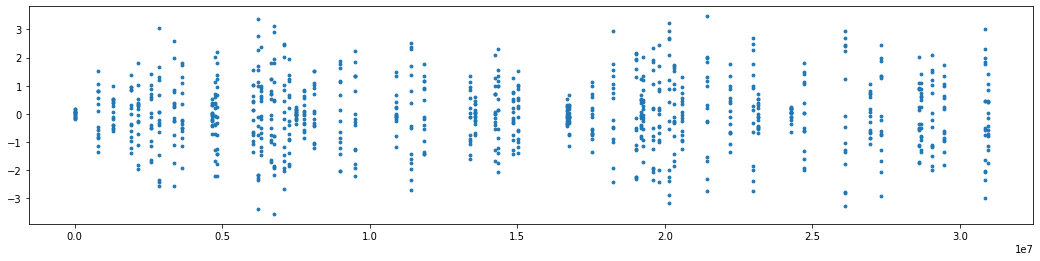

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))
ax.scatter(ts, rvs, s=8);

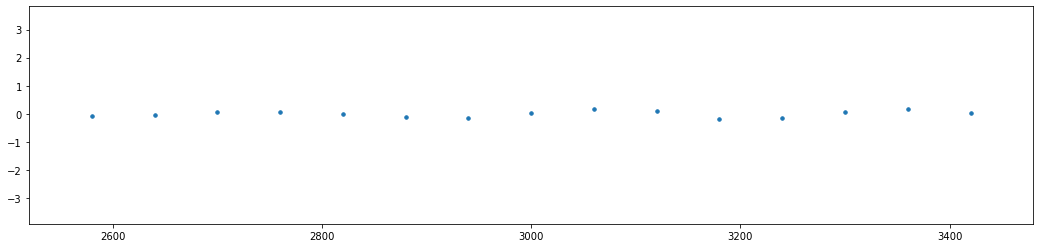

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))
ax.scatter(ts, rvs, s=12)
ax.set_xlim([start_ts[0] - 60, start_ts[0] + 900]);

In [17]:
t = ts
y = rvs
yerr = errs
t_grid = np.ravel([np.linspace(t - 60, t + 900, 100) for t in start_ts]) # fine grid around the observed times

In [18]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
22it [00:00, 732.19it/s, logp=-7.856577e+02]
message: Optimization terminated successfully.
logp: -1000.7642281750957 -> -785.657701306852


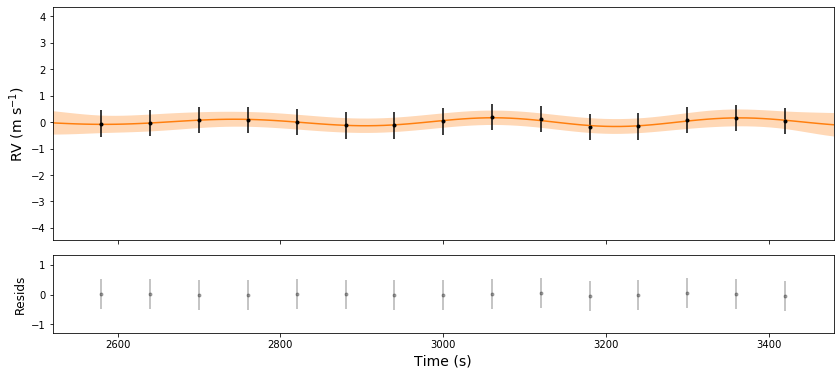

In [19]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})
                              
art = ax1.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_grid, mu, color="C1", label="prediction")

ax1.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")

ax2.errorbar(t, y - y_pred, yerr=yerr, fmt=".k", capsize=0, label="resids", alpha=0.3)

ax2.set_xlabel('Time (s)', fontsize=14)
ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=14)
ax2.set_ylabel('Resids', fontsize=12)

ax1.set_xlim([start_ts[0] - 60, start_ts[0] + 900]);

In [20]:
print("net RMS = {0:.2f} m/s".format(np.sqrt(np.sum((y - y_pred)**2/len(y)))))

net RMS = 0.20 m/s
